In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
ames_train = pd.read_csv(
    "https://cs307.org/lab-04/data/ames-train.csv",
)
ames_test = pd.read_csv(
    "https://cs307.org/lab-04/data/ames-test.csv",
)

In [3]:
ames_train

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      2832  908188140          160        RM          24.0      2522   Pave   
1      2736  905426150           80        RL           NaN     19690   Pave   
2      2135  907200130           20        RL          97.0     11800   Pave   
3      2424  528228415          120        RM           NaN      3072   Pave   
4      1967  535457020           20        RL          80.0      8000   Pave   
...     ...        ...          ...       ...           ...       ...    ...   
1870   1020  527302070           20        RL           NaN     10825   Pave   
1871    237  905426200           20        RL          65.0     11479   Pave   
1872   1547  910202050           30        RM          40.0      3636   Pave   
1873   1855  533251110           20        RL          80.0     12000   Pave   
1874   2836  908227030           50        RL          62.0      8707   Pave   

     Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0      NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
1      NaN       IR1          Lvl  ...       738      Gd  GdPrv          NaN   
2      NaN       IR1          Bnk  ...         0     NaN    NaN          NaN   
3      NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4      NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
...    ...       ...          ...  ...       ...     ...    ...          ...   
1870   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1871   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
1872   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
1873   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
1874   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   

     Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0           0       4    2006       WD           Normal     137500  
1           0       8    2006       WD           Alloca     274970  
2           0       8    2007       WD           Family     131000  
3           0       5    2006       WD           Normal     178740  
4           0      11    2007       WD           Normal     156500  
...       ...     ...     ...       ...             ...        ...  
1870        0       7    2008       WD           Normal     181900  
1871        0       6    2010       WD           Normal     144500  
1872        0       1    2008       WD           Normal      55000  
1873        0       3    2007       WD           Normal     255000  
1874        0       5    2006       WD          AdjLand     107000  

[1875 rows x 82 columns]

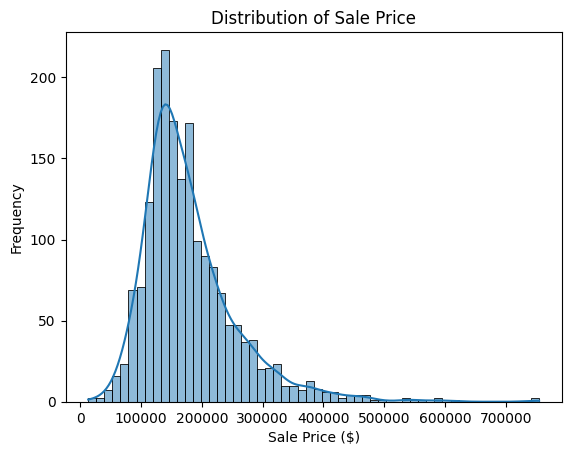

In [4]:
sns.histplot(ames_train["SalePrice"], kde=True)
plt.title("Distribution of Sale Price")
plt.xlabel("Sale Price ($)")
plt.ylabel("Frequency")
plt.show()

In [5]:
# create X and y for train dataset
X_train = ames_train.drop("SalePrice", axis=1)
y_train = ames_train["SalePrice"]

# create X and y for test dataset
X_test = ames_test.drop("SalePrice", axis=1)
y_test = ames_test["SalePrice"]

In [6]:
# helper function to find columns that are mostly missing
def columns_missing_above_threshold(df, threshold):
    missing_proportion = df.isnull().sum() / len(df)
    columns_above_threshold = missing_proportion[missing_proportion > threshold].index.tolist()
    return columns_above_threshold

In [7]:
# define columns to be excluded
many_missing_columns = columns_missing_above_threshold(X_train, 0.6)
exclude_columns = ["Order", "PID"] + many_missing_columns

# find columns with string data type (will be considered categorical)
string_columns = X_train.select_dtypes(include=["object"]).columns.tolist()
string_columns = [col for col in string_columns if col not in exclude_columns]

# find columns with numeric data type
numeric_columns = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

In [8]:
# pipeline for numeric
numeric_preprocessor = Pipeline(
    steps=[
        ("MedianImputer", SimpleImputer(strategy="median")),
        ("Standardize", StandardScaler()),
    ]
)

# pipeline for categorical
categorical_preprocessor = Pipeline(
    steps=[
        ("ModalImputer", SimpleImputer(strategy="most_frequent")),
        ("OneHotEncoder", OneHotEncoder(handle_unknown="infrequent_if_exist", max_categories=5)),
    ]
)

# column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("ExcludeColumns", "drop", exclude_columns),
        ("CategoricalPreprocessing", categorical_preprocessor, string_columns),
        ("NumericProcessing", numeric_preprocessor, numeric_columns),
    ],
    remainder="drop",
)

# full pipeline
pipeline = Pipeline(
    steps=[
        ("Preprocessor", preprocessor),
        ("Regressor", DummyRegressor()),
    ]
)

In [9]:
param_grid = [
    {
        "Regressor": [DummyRegressor()],
    },
    {
        "Regressor": [LinearRegression()],
    },
    {
        "Regressor": [KNeighborsRegressor()],
        "Regressor__n_neighbors": [1, 3, 5, 7, 9, 11, 15],
    },
    {
        "Regressor": [DecisionTreeRegressor()],
        "Regressor__max_depth": [1, 3, 5, 7, 9, 11, 15, None],
    },
    {
        "Regressor": [HistGradientBoostingRegressor()],
        "Regressor__learning_rate": [0.1, 0.01, 0.001],
        "Regressor__max_iter": [1000],
        "Regressor__max_depth": [None, 3],
        "Regressor__l2_regularization": [0.1, 1.0],
    },
]

In [10]:
pipeline

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('ExcludeColumns', 'drop',
                                                  ['Order', 'PID', 'Alley',
                                                   'Pool QC', 'Fence',
                                                   'Misc Feature']),
                                                 ('CategoricalPreprocessing',
                                                  Pipeline(steps=[('ModalImputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('OneHotEncoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 max_categories=5))]),
                                                  ['MS Zoning', 'St...
                                                   'Year Remod/Add',
                                                   'Mas Vnr Area',
                                                   'BsmtFin SF 1',
                                                   'BsmtFin SF 2',
                                                   'Bsmt Unf SF',
                                                   'Total Bsmt SF',
                                                   '1st Flr SF', '2nd Flr SF',
                                                   'Low Qual Fin SF',
                                                   'Gr Liv Area',
                                                   'Bsmt Full Bath',
                                                   'Bsmt Half Bath',
                                                   'Full Bath', 'Half Bath',
                                                   'Bedroom AbvGr',
                                                   'Kitchen AbvGr',
                                                   'TotRms AbvGrd',
                                                   'Fireplaces',
                                                   'Garage Yr Blt',
                                                   'Garage Cars', 'Garage Area',
                                                   'Wood Deck SF',
                                                   'Open Porch SF',
                                                   'Enclosed Porch', ...])])),
                ('Regressor', DummyRegressor())])

In [11]:
mod = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=2,
    scoring="neg_mean_absolute_percentage_error",
)

In [12]:
mod.fit(X_train, y_train)

Fitting 5 folds for each of 29 candidates, totalling 145 fits
[CV] END .........................Regressor=DummyRegressor(); total time=   0.1s
[CV] END .........................Regressor=DummyRegressor(); total time=   0.1s
[CV] END .........................Regressor=DummyRegressor(); total time=   0.1s
[CV] END .......................Regressor=LinearRegression(); total time=   0.1s
[CV] END Regressor=KNeighborsRegressor(), Regressor__n_neighbors=1; total time=   0.1s
[CV] END .........................Regressor=DummyRegressor(); total time=   0.1s
[CV] END .........................Regressor=DummyRegressor(); total time=   0.1s
[CV] END Regressor=KNeighborsRegressor(), Regressor__n_neighbors=1; total time=   0.1s
[CV] END Regressor=KNeighborsRegressor(), Regressor__n_neighbors=1; total time=   0.1s
[CV] END Regressor=KNeighborsRegressor(), Regressor__n_neighbors=1; total time=   0.1s
[CV] END .......................Regressor=LinearRegression(); total time=   0.2s
[CV] END ..............

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessor',
                                        ColumnTransformer(transformers=[('ExcludeColumns',
                                                                         'drop',
                                                                         ['Order',
                                                                          'PID',
                                                                          'Alley',
                                                                          'Pool '
                                                                          'QC',
                                                                          'Fence',
                                                                          'Misc '
                                                                          'Feature']),
                                                                        ('CategoricalPreprocessing',
                                                                         Pipeline(steps=[('ModalImputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('OneHotEncoder',
                                                                                          OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                        max_...
                          'Regressor__n_neighbors': [1, 3, 5, 7, 9, 11, 15]},
                         {'Regressor': [DecisionTreeRegressor()],
                          'Regressor__max_depth': [1, 3, 5, 7, 9, 11, 15,
                                                   None]},
                         {'Regressor': [HistGradientBoostingRegressor()],
                          'Regressor__l2_regularization': [0.1, 1.0],
                          'Regressor__learning_rate': [0.1, 0.01, 0.001],
                          'Regressor__max_depth': [None, 3],
                          'Regressor__max_iter': [1000]}],
             scoring='neg_mean_absolute_percentage_error', verbose=2)

In [13]:
mod.best_params_

{'Regressor': HistGradientBoostingRegressor(),
 'Regressor__l2_regularization': 1.0,
 'Regressor__learning_rate': 0.01,
 'Regressor__max_depth': None,
 'Regressor__max_iter': 1000}

In [14]:
# mod.cv_results_

In [15]:
print(f"CV MAPE: {-mod.best_score_}")

CV MAPE: 0.09323748138117231


In [16]:
y_test_pred = mod.predict(X_test)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
print(f"Test MAPE: {test_mape}")

Test MAPE: 0.08164649164771304
